In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt

# 資料轉換函數
transform = transforms.Compose([
    transforms.ToTensor(), # 轉為 Tensor
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # 灰階轉為 RGB
])

In [2]:
# 建立 EMNIST 的 Dataset
emnist_train = datasets.EMNIST(
    root='./data',       # 資料放置路徑
    train=True,          # 訓練資料集
    download=True,       # 自動下載
    transform=transform,  # 轉換函數
    split = 'byclass' 
)
emnist_test = datasets.EMNIST(
    root='./data',       # 資料放置路徑
    train=False,         # 測試資料集
    download=True,       # 自動下載
    transform=transform,  # 轉換函數
    split = 'byclass' 
)
print("訓練資料集數量：", len(emnist_train))
print("測試資料集數量：", len(emnist_test))

訓練資料集數量： 697932
測試資料集數量： 116323


In [3]:
# 批次載入資料筆數
batch_size = 512
# 建立 DataLoader
train_loader = torch.utils.data.DataLoader(emnist_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(emnist_test, batch_size=batch_size)


Shape of X [N, C, H, W]:  torch.Size([512, 3, 28, 28])
Shape of y:  torch.Size([512]) torch.int64


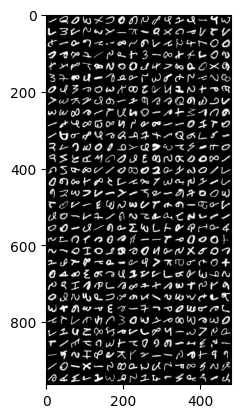

In [4]:
# 測試以 DataLoader 載入資料
for X, y in test_loader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)

    # 顯示 MNIST 數字圖片
    img = utils.make_grid(X, nrow=16)
    plt.imshow(img.numpy().transpose((1, 2, 0)))
    plt.show()

    break

In [5]:
# 定義類神經網路模型
class EMNIST_ResNet152(nn.Module):
    def __init__(self):
        super(EMNIST_ResNet152, self).__init__()

        # 載入 ResNet152 類神經網路結構
        self.model = models.resnet152(pretrained=True)

        # 鎖定 ResNet152 預訓練模型參數
        #for param in self.model.parameters():
        #    param.requires_grad = False

        # 修改輸出層輸出數量
        self.model.fc = nn.Linear(2048, 62)

    def forward(self, x):
        logits = self.model(x)
        return logits

In [6]:
device = torch.device("cuda") 

In [7]:
# 建立類神經網路模型，並放置於 GPU 或 CPU 上
model = EMNIST_ResNet152().to(device)
print(model)

c:\Users\ASUS\anaconda3\envs\pt\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\anaconda3\envs\pt\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EMNIST_ResNet152(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [8]:
# 損失函數
loss_fn = nn.CrossEntropyLoss()

# 學習優化器
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [9]:
# 訓練模型
def train(dataloader, model, loss_fn, optimizer,losses1):
    # 資料總筆數
    size = len(dataloader.dataset)

    # 將模型設定為訓練模式
    model.train()

    # 批次讀取資料進行訓練
    for batch, (X, y) in enumerate(dataloader):
        # 將資料放置於 GPU 或 CPU
        X, y = X.to(device), y.to(device)

        pred = model(X)         # 計算預測值
        loss = loss_fn(pred, y) # 計算損失值（loss）

        optimizer.zero_grad()   # 重設參數梯度（gradient）
        loss.backward()         # 反向傳播（backpropagation）
        optimizer.step()        # 更新參數

        # 輸出訓練過程資訊
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            losses1.append(loss)

In [10]:
# 測試模型
def test(dataloader, model, loss_fn,losses2,Accuracy):
    # 資料總筆數
    size = len(dataloader.dataset)

    # 批次數量
    num_batches = len(dataloader)

    # 將模型設定為驗證模式
    model.eval()

    # 初始化數值
    test_loss, correct = 0, 0

    # 驗證模型準確度
    with torch.no_grad():  # 不要計算參數梯度
        for X, y in dataloader:
            # 將資料放置於 GPU 或 CPU
            X, y = X.to(device), y.to(device)

            # 計算預測值
            pred = model(X)

            # 計算損失值的加總值
            test_loss += loss_fn(pred, y).item()

            # 計算預測正確數量的加總值
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # 計算平均損失值與正確率
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    losses2.append(test_loss)
    Accuracy.append(100*correct)

In [11]:
losses1 = []
losses2 = []
Accuracy=[]
# 設定 epochs 數
epochs = 3
# 開始訓練模型
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer,losses1)
    test(test_loader, model, loss_fn,losses2,Accuracy)
print("完成！")

Epoch 1
-------------------------------


loss: 4.246027  [    0/697932]
loss: 1.207313  [51200/697932]
loss: 0.689404  [102400/697932]
loss: 0.494096  [153600/697932]
loss: 0.501791  [204800/697932]
loss: 0.392555  [256000/697932]
loss: 0.370930  [307200/697932]
loss: 0.436580  [358400/697932]
loss: 0.423153  [409600/697932]
loss: 0.389942  [460800/697932]
loss: 0.355727  [512000/697932]
loss: 0.404413  [563200/697932]
loss: 0.415320  [614400/697932]
loss: 0.380842  [665600/697932]
Test Error: 
 Accuracy: 86.2%, Avg loss: 0.378417 

Epoch 2
-------------------------------
loss: 0.381789  [    0/697932]
loss: 0.367164  [51200/697932]
loss: 0.360253  [102400/697932]
loss: 0.330923  [153600/697932]
loss: 0.351582  [204800/697932]
loss: 0.314957  [256000/697932]
loss: 0.286813  [307200/697932]
loss: 0.347520  [358400/697932]
loss: 0.339472  [409600/697932]
loss: 0.320756  [460800/697932]
loss: 0.294308  [512000/697932]
loss: 0.339537  [563200/697932]
loss: 0.353103  [614400/697932]
loss: 0.351322  [665600/697932]
Test Error: 
 Ac

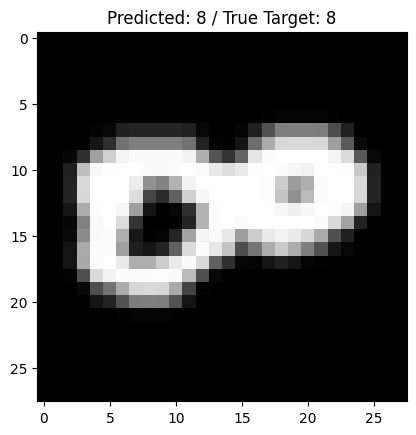

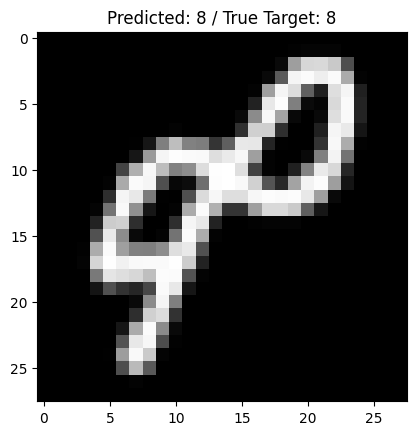

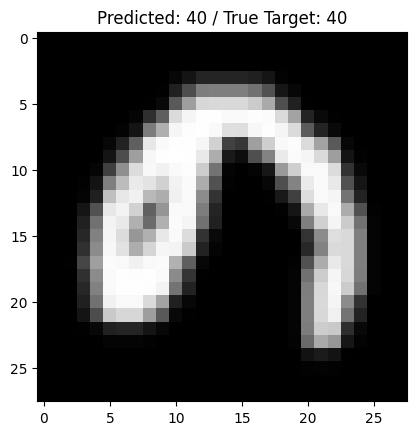

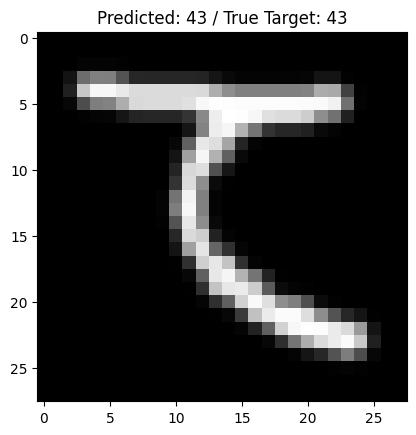

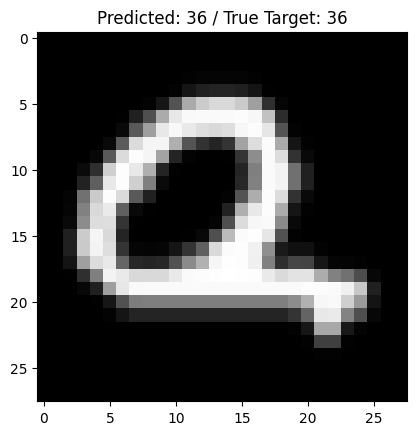

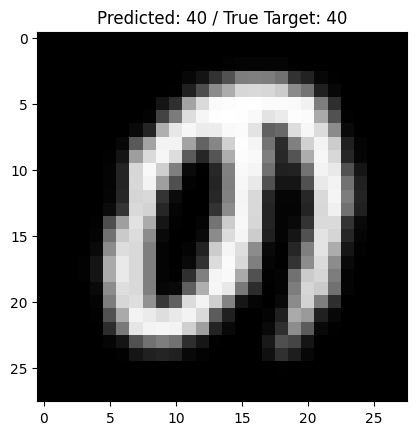

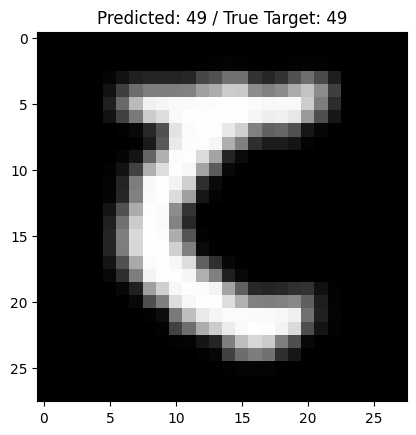

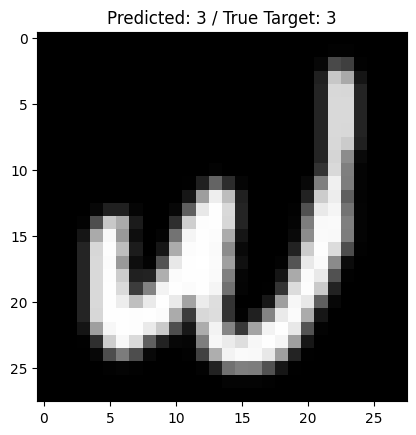

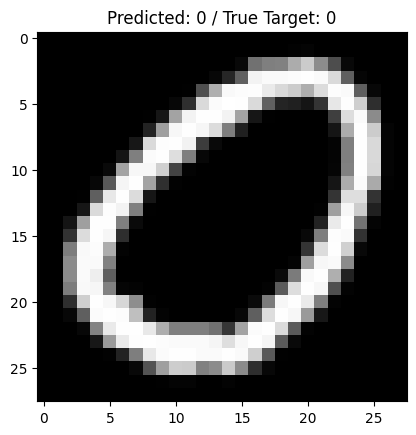

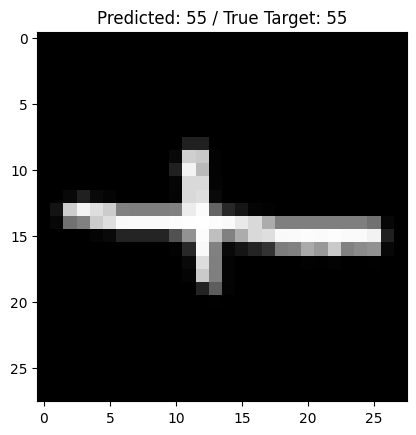

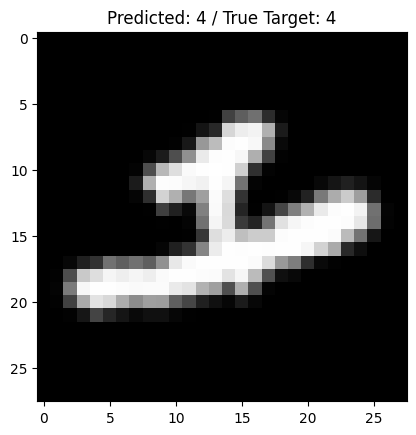

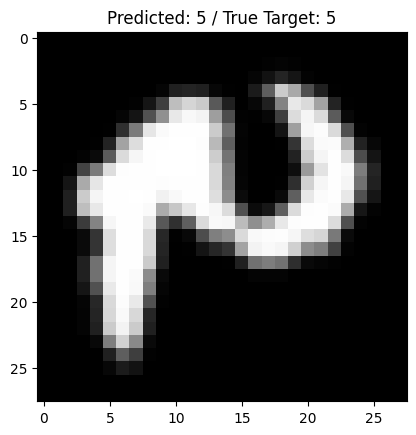

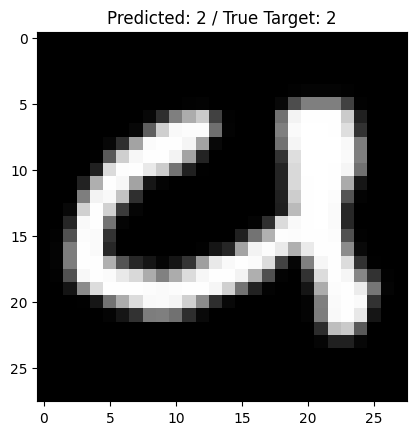

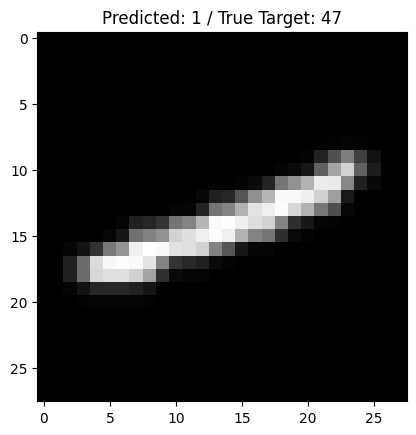

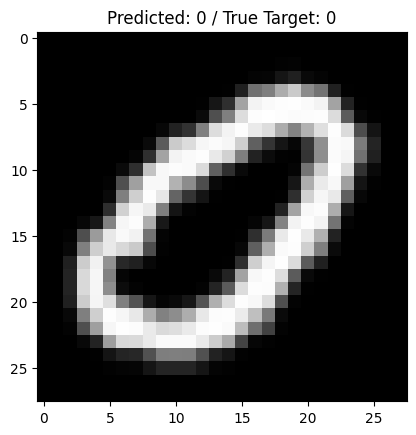

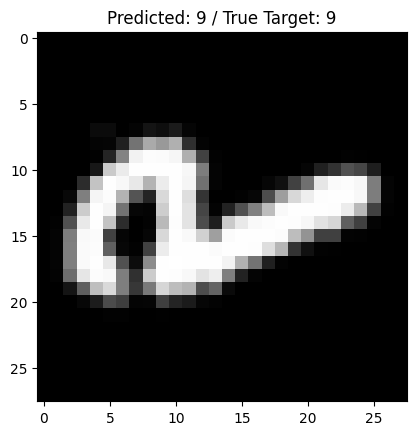

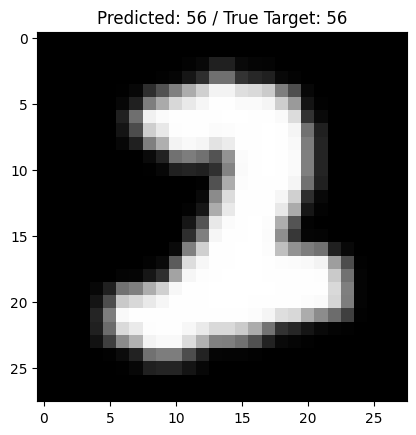

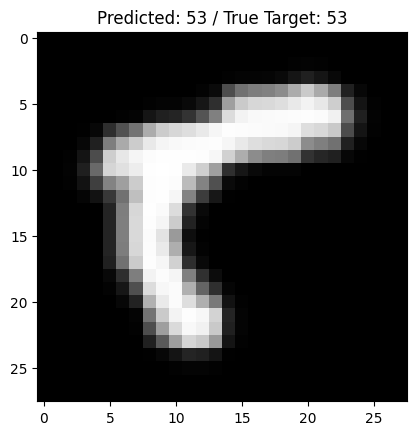

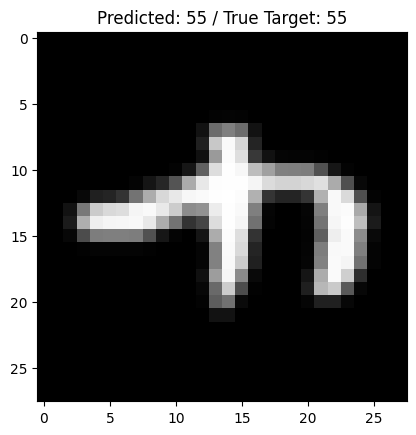

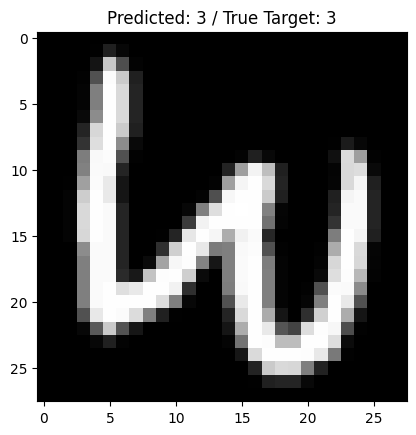

In [12]:
with torch.no_grad():
    indices=[]
    for i in range(20):
        im=100000
        indices.append(im+i)
    images = torch.stack([emnist_test[i][0] for i in indices])  # Get the images
    true_targets = [emnist_test[i][1] for i in indices]  # Get the true targets
    images = images.to(device)

    predictions = model(images)
    predicted_classes = predictions.argmax(dim=1)

    for i in range(len(indices)):
        np_image = images[i].cpu().numpy()[0]  # Select the first channel and convert to NumPy array
        plt.imshow(np_image, cmap='gray')
        plt.title(f'Predicted: {predicted_classes[i]} / True Target: {true_targets[i]}')
        plt.show()

In [14]:
X=torch.rand(512,3,28,28).to(device)
trace_model=torch.jit.trace(model,X)
torch.jit.save(trace_model, 'static/model.pth')

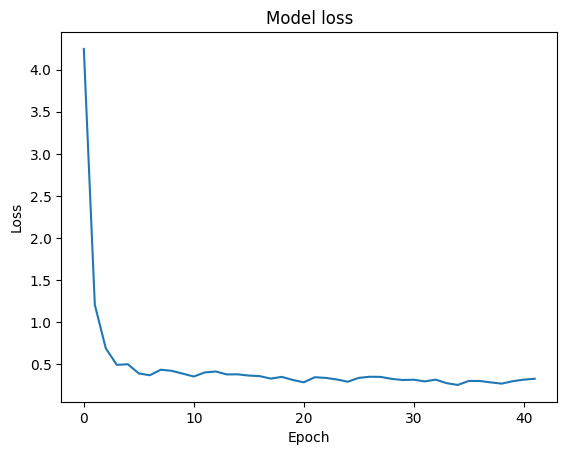

In [15]:
plt.plot(losses1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model loss')
plt.show()

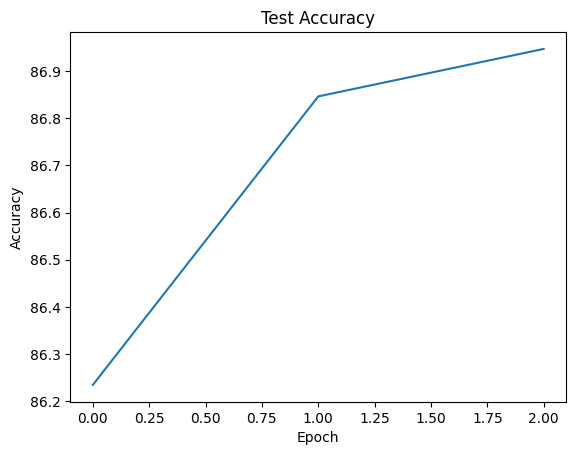

In [16]:
plt.plot(Accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.show()

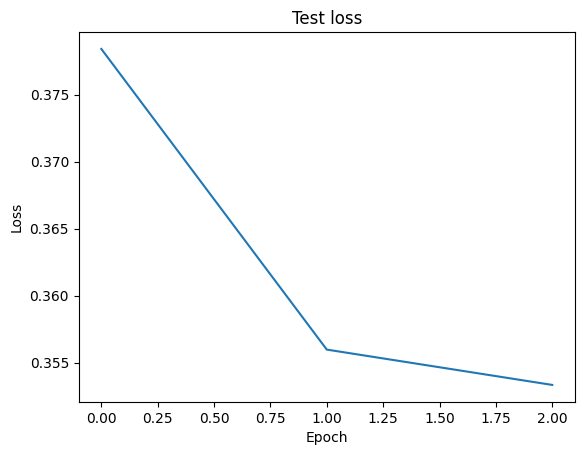

In [17]:
plt.plot(losses2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test loss')
plt.show()

c:\Users\ASUS\anaconda3\envs\pt\lib\site-packages\torch\serialization.py:799: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"
C:\Users\ASUS\AppData\Local\Temp\ipykernel_2020\2680497495.py:58: RuntimeWarning: invalid value encountered in divide
  per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)                    # https://stackoverflow.com/a/53824126/13369757


['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[0.71256902 0.69228862 0.96295673 0.99132031 0.96563815 0.95556422
 0.96932621 0.99088838 0.97965322 0.93262591 0.93417493 0.94272446
 0.780407   0.9        0.96616103 0.7693575  0.92253521 0.90976059
 0.68970699 0.91273997 0.62808349 0.89244851 0.75412371 0.93045897
 0.61835863 0.85551075 0.88625592 0.92890995 0.82973922 0.94458763
 0.7764277  0.67129136 0.78900112 0.84453782 0.77920411 0.67058824
 0.92765957 0.92757306 0.53658537 0.98680264 0.98355828 0.59090909
 0.61954625 0.96227709 0.82065217 0.71346705 0.84175084 0.47666278
 0.45454545 0.96306355        nan 0.57857143 0.74654378 0.96804836
 0.45454545 0.94608985 0.49019608 0.58536585 0.76502732 0.62688822
 0.53135314 0.68269

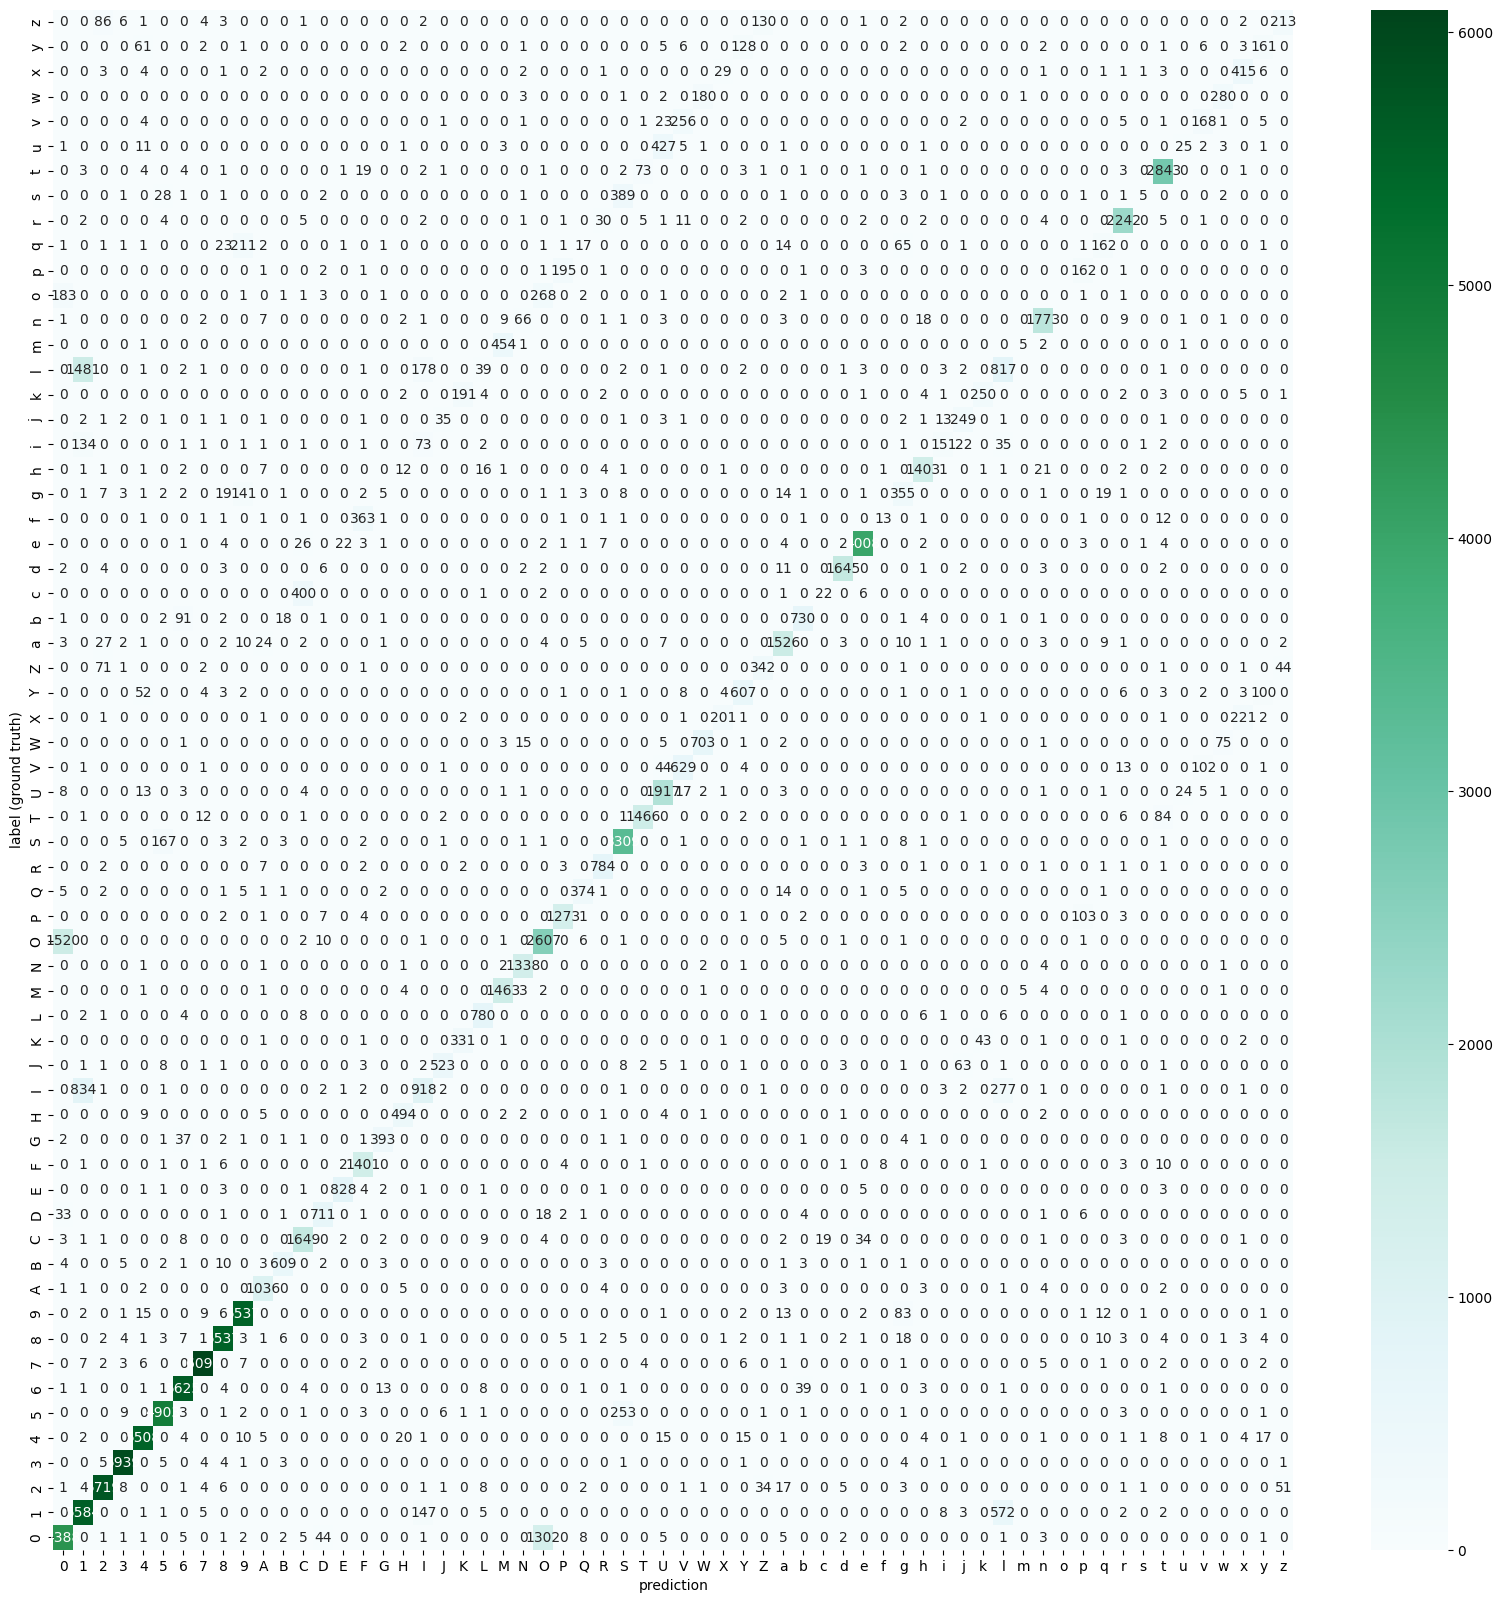

In [18]:
import os
import random
import shutil
import time
import json
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
batch_size = 2048
# 建立 DataLoader
test_loader = torch.utils.data.DataLoader(emnist_test, batch_size=batch_size)
y_pred = []   #保存預測label
y_true = []   #保存實際label

def validate(test_loader, model, y_pred, y_true):
    model = torch.load('static/model.pth', map_location=device)
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(test_loader):

            target = target.cuda(non_blocking=True)
            images = images.to(device)
            output = model(images)
            _, preds = torch.max(output, 1)                            # preds是預測結果
            
            y_pred.extend(preds.view(-1).detach().cpu().numpy())       # 將preds預測結果detach出來，並轉成numpy格式       
            y_true.extend(target.view(-1).detach().cpu().numpy())      # target是ground-truth的label
        
    return y_pred, y_true


y_pred, y_true = validate(test_loader, model, y_pred,y_true)

# 製作混淆矩陣
cf_matrix = confusion_matrix(y_true, y_pred)                                # https://christianbernecker.medium.com/how-to-create-a-confusion-matrix-in-pytorch-38d06a7f04b7
# 計算每個class的accuracy
per_cls_acc = cf_matrix.diagonal()/cf_matrix.sum(axis=0)                    # https://stackoverflow.com/a/53824126/13369757
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
print(class_names)
print(per_cls_acc)                                                          #顯示每個class的Accuracy
print("Plot confusion matrix")

# 開始繪製混淆矩陣並存檔
df_cm = pd.DataFrame(cf_matrix[::-1], class_names[::-1], class_names)     # https://sofiadutta.github.io/datascience-ipynbs/pytorch/Image-Classification-using-PyTorch.html
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.savefig("confusion_matrix.png")